# Markov Chain Model for Predicting Men's College Basketball Games

* See Diagram explaining Markov Chain process

For the initial team-level Markov Chain model, all stats will be taken as per game stats at the team level. Future work will seek to refine this approach by modeling player-level dynamics.

Stats of Interest:
 * Offensive Rebounding Efficiency (Offensive Rebounds / Offensive Rebound Opportunities)
 * Two-Point Attempts 
 * Three-Point Attempts
 * Two-Point Shooting Percentage (Shots Made / Shots Attempted)
 * Three-Point Shooting Percentage
 * Opponent Free Throw attempts
 * Free Throw attempts
 * Free Throw Percentage
 * Turnovers
 * Opponent Turnovers
 * AdjT (KenPom Adjusted Tempo)
 
*Data Format*: Initial explorations of this model will utilize end-of-season stats for each team, as it is difficult to accurately time-slice historical stats. However, it is important to note that this will essentially allow the model to be trained on the test data (If a team's end-of-season stats were good, its likely that they won games), which could result in an artifically inflated predictive capability. Future work will seek to remedy this leakage by either projecting the previous season's stats forward or by only using stats up to the game in question. Finally, time and opponent weighting can be added to the stats in order to more accurately capture the team's ability at a given moment in time. This project's primary data sources are listed below:
 * [Year] Stats: The stats of interest for each D-1 NCAA team for a given year. This will likely be stored in a csv file for easy storage and retrieval, and will be loaded into a pandas dataframe for use within the project.
 * [Year] Results: Every game between two D-1 NCAA teams in a given season, with the resulting scores. Similarly to the stats, this will be stored in a csv file and loaded into a pandas dataframe for project use.
    
Assumptions:
 * As the two outcomes of fouls are free throws or a turnover, we use these two stats in the model instead of the number of fouls
     * We do not care if a turnover is a result of a foul, error, or steal, as these are all functionally identical
     * We assume that free throws are shot 2 at a time, independently of two and three point shots. While this is quite different to how free throws function in actuality, this should still accurately capture a team's scoring from the free throw line. Additionally, we assume that there are no offensive rebounds after free-throws, as teams rarely contest free throws.
 * The total amount of possessions in the game is the sum of both teams' KenPom Adjusted Tempo. As a result, teams who tend to run at higher tempo will have more event-dense games. We do not dictate a set number of possessions per team as that would defeat the stochastic nature of the Markov Chain Model
     * Each shot represents the end of one possession, even if the shooting team recovers their shot (offensive rebound)
 * Whether a team shoots a three-pointer or two-pointer is based on their ratio of three-point attempts to two-point attempts
 * Whether a team makes a shot or not is modeled as a Bernoulli random variable, where the probability of success is their shooting percentage for the shot type. Currently does not account for defense of other team.
     * Similarly, whether a team has an offensive rebound is modeled as a Bernoulli random variable, where the probability of success is their offensive rebounding efficiency. This was chosen due both to its simplicity and by assuming defensive rebounds as the default. This could be refined in the future by accounting for the opposing team's defensive rebounding efficiency.

### Step 1: Create Markov Chain Model

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time

class MarkovModel:
    def __init__(self, stats, home, away):
        '''Model Inputs:
            * stats (df): Pandas dataframe containing stats of interest for D-1 Teams
            * home (str): Home team name
            * away (str): Away team name'''
        self.states = ["Home Team Possession", "Away Team Possession", "Home 3PT Shot", "Home 2PT Shot", "Home FT Shot",
                       "Home 3PT Made", "Home 2PT Made", "Home Miss", "Away 3PT Shot", "Away 2PT Shot", "Away FT Shot", 
                       "Away 3PT Made", "Away 2PT Made", "Away Miss"]
        self.state_locations = np.arange(0,len(self.states))
        self.transition_matrix = self.create_transition_matrix(stats, home, away)
        #Store inputs after transition matrix has been generated
        self.home = home
        self.away = away
        self.home_ft_pct = stats.loc[home]["FT%"]
        self.away_ft_pct = stats.loc[away]["FT%"]
        self.total_possessions = stats.loc[home]["AdjT"] + stats.loc[away]["AdjT"]
        
    def create_transition_matrix(self, stats, home, away):
        home_stats = stats.loc[home]
        away_stats = stats.loc[away]
        home_turnover_rate = (home_stats["Turnovers"]+away_stats["Opp Turnovers"])/(2*home_stats["AdjT"])
        away_turnover_rate = (away_stats["Turnovers"]+home_stats["Opp Turnovers"])/(2*away_stats["AdjT"])
        home_shot_ratio = home_stats["2PTA"]/home_stats["3PTA"]
        away_shot_ratio = away_stats["2PTA"]/away_stats["3PTA"]
        home_ft_rate = (home_stats["FTA"]+away_stats["Opp FTA"])/(4*home_stats["AdjT"])
        away_ft_rate = (away_stats["FTA"]+home_stats["Opp FTA"])/(4*away_stats["AdjT"])
        transition_matrix = np.zeros((len(self.states),len(self.states)))
        transition_matrix[0,1] = home_turnover_rate
        transition_matrix[0,2] = (1-home_turnover_rate-home_ft_rate)/(home_shot_ratio+1)
        transition_matrix[0,4] = home_ft_rate
        transition_matrix[0,3] = 1 - sum(transition_matrix[0,:])
        transition_matrix[1,0] = away_turnover_rate
        transition_matrix[1,7] = (1-away_turnover_rate-away_ft_rate)/(away_shot_ratio+1)
        transition_matrix[1,10] = away_ft_rate
        transition_matrix[1,8] = 1 - sum(transition_matrix[1,:])
        transition_matrix[2,5] = home_stats["3PT%"]
        transition_matrix[2,7] = 1 - home_stats["3PT%"]
        transition_matrix[3,6] = home_stats["2PT%"]
        transition_matrix[3,7] = 1 - home_stats["2PT%"]
        transition_matrix[4:7,1] = 1
        transition_matrix[7,0] = home_stats["ORB%"]
        transition_matrix[7,1] = 1 - home_stats["ORB%"]
        transition_matrix[8,11] = home_stats["3PT%"]
        transition_matrix[8,13] = 1 - home_stats["3PT%"]
        transition_matrix[9,12] = home_stats["2PT%"]
        transition_matrix[9,13] = 1 - home_stats["2PT%"]
        transition_matrix[10:13,0] = 1
        transition_matrix[13,0] = 1 - away_stats["ORB%"]
        transition_matrix[13,1] = away_stats["ORB%"]
        valid = True
        for i in range(len(self.states)):
            if not np.isclose(sum(transition_matrix[i,:]), 1):
                valid = False
                break
        if not valid:
            print("Error in Transition Matrix")
            print(transition_matrix[i,:])
            sys.exit()
        return transition_matrix
    
    def simulate_game(self):
        self.current_state = int(np.round(np.random.uniform())) #Simulate coin flip for opening possession (Either 0 or 1)
        self.home_score = 0
        self.away_score = 0
        poss = 1
        while poss < self.total_possessions:
            # Transition to new state based on transition matrix
            self.current_state = np.random.choice(self.state_locations, replace=True, p=self.transition_matrix[self.current_state])
            if (self.current_state == 0) or (self.current_state == 1):
                #If a team has just gained possession, increment possession counter
                poss += 1
            elif self.current_state == 4:
                #Simulate free throws
                self.home_score += np.random.binomial(2, self.home_ft_pct)
            elif self.current_state == 5:
                #Increment scoring as appropriate
                self.home_score += 3
            elif self.current_state == 6:
                self.home_score += 2
            elif self.current_state == 10:
                self.away_score += np.random.binomial(2, self.away_ft_pct)
            elif self.current_state == 11:
                self.away_score += 3
            elif self.current_state == 12:
                self.away_score += 2
            

### Step 2: Collect Historical Data 

Monte Carlo Markov Chain Simulation. Final Score: Purdue-60.037, Michigan State-51.887
Total Simulation Time: 4.5797 seconds


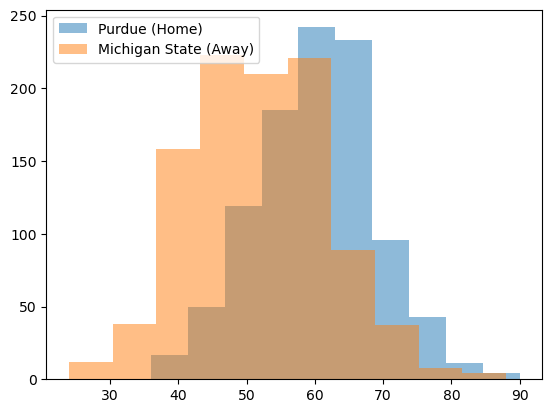

In [24]:
t1 = time.time()
last_year_stats = pd.read_csv("2021-22 Stats Mk2.csv", index_col=0)
last_year_markov_model = MarkovModel(last_year_stats, "Purdue", "Michigan State")
home_scores = []
away_scores = []
for i in range(1000):
    last_year_markov_model.simulate_game()
    home_scores.append(last_year_markov_model.home_score)
    away_scores.append(last_year_markov_model.away_score)
    
t2 = time.time()
print("Monte Carlo Markov Chain Simulation. Final Score: {}-{}, {}-{}".format(last_year_markov_model.home, np.mean(home_scores), last_year_markov_model.away, np.mean(away_scores)))
print("Total Simulation Time: {:.4f} seconds".format(t2-t1))
plt.hist(home_scores, alpha=0.5, label="Purdue (Home)")
plt.hist(away_scores, alpha=0.5, label="Michigan State (Away)")
plt.legend()

As we can see above, performing a Monte Carlo Simulation with our Markov Chain model produces the expected normal distributions for each team's score in the given matchup. As expected, there is a large degree of overlap between the two distributions, which represents the significant amount of uncertainty present in any given matchup. The model takes approximately 15 seconds to simulate 1,000 games, which is sufficient for confidently declaring a predicted winner. The algorithm is $O(N)$ with regards to number of games being simulated, so simulating larger numbers of games (>10,000) is feasible if desired. Simulating an entire season (\~5,000 matchups) at 1,000 sims per matchup would take \~20 hours to finish, so we will use 100 sims per matchup for our historical backtesting (\~2 hours).

[Backtest against historical data]

In [25]:
odds_df = pd.read_csv("2021-22 Odds.csv")
stats_df = pd.read_csv("2021-22 Stats Mk2.csv", index_col=0)

odds_df["Date"] = pd.to_datetime(odds_df["Date"], format="t%m%d%Y")
home_predictions = []
away_predictions = []
for matchup in odds_df.itertuples(index=False, name=None):
    print(matchup[0])
    try:
        mm = MarkovModel(stats_df, matchup[1], matchup[4])
        home_scores = []
        away_scores = []
        for i in range(100):
            mm.simulate_game()
            home_scores.append(mm.home_score)
            away_scores.append(mm.away_score)
        home_predictions.append(np.mean(home_scores))
        away_predictions.append(np.mean(away_scores))
    except:
        print("Key Error, Teams: {}, {}".format(matchup[1], matchup[4]))
        break

odds_df["Home Predictions"] = home_predictions
odds_df["Away Predictions"] = away_predictions
odds_df.to_csv("2021-22 Markov Preds Mk2.csv")

2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00
2021-11-09 00:00:00


2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-17 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00
2021-11-18 00:00:00


2021-11-25 00:00:00
2021-11-25 00:00:00
2021-11-25 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00
2021-11-26 00:00:00


2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-05 00:00:00
2021-12-06 00:00:00
2021-12-06 00:00:00
2021-12-06 00:00:00
2021-12-06 00:00:00
2021-12-06 00:00:00
2021-12-06 00:00:00
2021-12-06 00:00:00
2021-12-06 00:00:00
2021-12-06 00:00:00
2021-12-06 00:00:00
2021-12-06 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00
2021-12-07 00:00:00


2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-18 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-19 00:00:00
2021-12-20 00:00:00
2021-12-20 00:00:00
2021-12-20 00:00:00
2021-12-20 00:00:00
2021-12-20 00:00:00
2021-12-20 00:00:00
2021-12-20 00:00:00
2021-12-20 00:00:00


2022-01-06 00:00:00
2022-01-06 00:00:00
2022-01-06 00:00:00
2022-01-06 00:00:00
2022-01-06 00:00:00
2022-01-06 00:00:00
2022-01-06 00:00:00
2022-01-06 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-07 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00
2022-01-08 00:00:00


2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-15 00:00:00
2022-01-16 00:00:00
2022-01-16 00:00:00
2022-01-16 00:00:00
2022-01-16 00:00:00
2022-01-16 00:00:00
2022-01-16 00:00:00
2022-01-16 00:00:00
2022-01-16 00:00:00
2022-01-16 00:00:00
2022-01-16 00:00:00
2022-01-16 00:00:00
2022-01-16 00:00:00
2022-01-16 00:00:00


2022-01-23 00:00:00
2022-01-23 00:00:00
2022-01-23 00:00:00
2022-01-23 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-24 00:00:00
2022-01-25 00:00:00
2022-01-25 00:00:00
2022-01-25 00:00:00
2022-01-25 00:00:00
2022-01-25 00:00:00
2022-01-25 00:00:00
2022-01-25 00:00:00


2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-01 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00
2022-02-02 00:00:00


2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-09 00:00:00
2022-02-10 00:00:00
2022-02-10 00:00:00
2022-02-10 00:00:00
2022-02-10 00:00:00
2022-02-10 00:00:00
2022-02-10 00:00:00
2022-02-10 00:00:00
2022-02-10 00:00:00


2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00
2022-02-17 00:00:00


2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-24 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-25 00:00:00
2022-02-26 00:00:00
2022-02-26 00:00:00
2022-02-26 00:00:00
2022-02-26 00:00:00
2022-02-26 00:00:00
2022-02-26 00:00:00
2022-02-26 00:00:00
2022-02-26 00:00:00
2022-02-26 00:00:00


2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00
2022-03-05 00:00:00


2022-03-26 00:00:00
2022-03-26 00:00:00
2022-03-27 00:00:00
2022-03-27 00:00:00
2022-03-28 00:00:00
2022-03-28 00:00:00
2022-03-29 00:00:00
2022-03-29 00:00:00
2022-03-31 00:00:00
2022-04-01 00:00:00
2022-04-02 00:00:00
2022-04-02 00:00:00
2022-04-04 00:00:00


Text(0, 0.5, 'Predicted Scores')

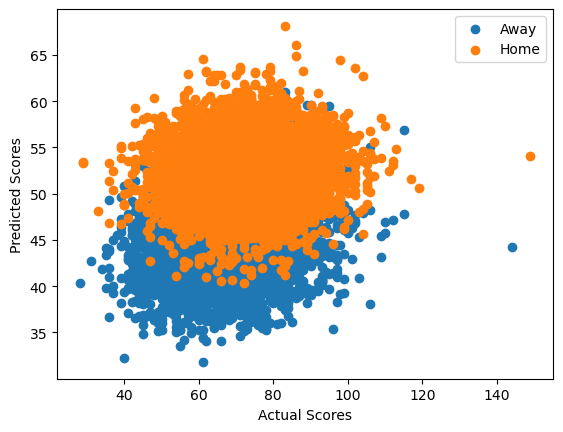

In [26]:
results_df = pd.read_csv("2021-22 Markov Preds Mk2.csv", index_col = 0)
plt.scatter(results_df["Away Score"], results_df["Away Predictions"], label="Away")
plt.scatter(results_df["Home Score"], results_df["Home Predictions"], label="Home")
plt.legend()
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")

In [27]:
def american_to_decimal(odds):
    #Convert American Odds to Decimal Odds
    if odds < 0: #If team is the favorite (negative american odds)
        decimal_odds = -1/(odds/100) + 1
    else:
        decimal_odds = (odds/100) + 1
    return decimal_odds

results_df["Away ML"] = results_df["Away ML"].astype(float)
results_df["Home ML"] = results_df["Home ML"].astype(float)
#Convert American odds to decimal odds
results_df['Away ML'] = results_df['Away ML'].apply(american_to_decimal)
results_df["Home ML"] = results_df["Home ML"].apply(american_to_decimal)


results_df["Markov Profit"] = np.where(results_df["Away Predictions"] > results_df["Home Predictions"], 
                                    np.where(results_df["Away Score"] > results_df["Home Score"], results_df["Away ML"]-1, -1),
                                    np.where(results_df["Home Score"] > results_df["Away Score"], results_df["Home ML"]-1, -1))

print("Markov Profit (Units/Game): {:.4f}".format(np.mean(results_df["Markov Profit"])))
print("Markov Accuracy: {:.2%}".format(np.mean(results_df["Markov Profit"] > 0)))
print("Cumulative Markov Profit (Units): {:.2f}".format(results_df["Markov Profit"].sum()))

Markov Profit (Units/Game): -0.0422
Markov Accuracy: 60.86%
Cumulative Markov Profit (Units): -225.29


## Future Improvements

* Analyze distribution of team stats per game to chose more accurate distributions
  * Current Model intrisincally assumes that shots, steals, and offensive rebounds follow a binomial distribution with mean *np*, which implies a variance of *np(1-p)* and symmetric distribution
  * However, maybe offensive rebounds (or another stat) follow a poisson distribution with mean and variance  $\lambda$
* Add additional states to the Markov Model
  * Personal fouls and free throw percentage
* Implement a player-level Markov Model